In [1]:
# YIKAI MAO

# generate wiki page data

In [2]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qpy
from qiskit_aer import AerProvider, AerSimulator
from qiskit.visualization import *
from qiskit.circuit import Parameter
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate, EfficientSU2, ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.extensions import Initialize

# other libraries
import time
import math
import pickle
import gzip
from random import sample, choice
import numpy as np
from numpy import pi
import networkx as nx
from tqdm import tqdm # use: tqdm(iterable)
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
from sklearn.metrics import r2_score

print('-'*44)
print("available simulators:")
display(AerProvider().backends())
print('-'*44)
print("available simulation methods:")
display(AerSimulator().available_methods())
print('-'*44)
print("available devices:")
display(AerSimulator().available_devices())
print('-'*44)

env: PYTHONHASHSEED=0
--------------------------------------------
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

--------------------------------------------
available simulation methods:


('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop',
 'tensor_network')

--------------------------------------------
available devices:


('CPU', 'GPU')

--------------------------------------------


In [3]:
# utility functions

def run_ideal_simulation(circuit, device, shots, optimization_level, seed, verbose):
    # assume perfect device with no noise
    # circuit = circuit to simulate, NOT transpiled
    # device = 'CPU' or 'GPU'
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # verbose = T/F

    if device == 'GPU':
        simulator = AerSimulator(device='GPU', cuStateVec_enable=True)
    elif device == 'CPU':
        simulator = AerSimulator(device='CPU')

    if verbose:
        print('---------------------------------------START')
        print('simulator name =', simulator.configuration().to_dict()['backend_name'])
        print('max supported #qubits =', simulator.configuration().to_dict()['n_qubits'])

        print('#qubits of circuit =', circuit.num_qubits)
        print('#clbits of circuit =', circuit.num_clbits)

    if circuit.num_qubits > simulator.configuration().to_dict()['n_qubits']:
        print('too many qubits for the simulator!')
        print('----------------------------------------FAIL')
        return None

    trans_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job = simulator.run(trans_qc, shots=shots, seed_simulator=seed)
    result = job.result()

    if verbose:
        print('-------------------------------------SUCCESS')
    
    return result

def sim_result_analysis(sim_result, sort, show_plot, show_counts, verbose):
    # show_plot = T/F, plot result
    # show_counts = T/F, show sorted counts

    result_dict = sim_result.to_dict()

    if result_dict['status'] != 'COMPLETED':
        print(result_dict['status'])
        return

    device = result_dict['results'][0]['metadata']['device']
    # https://qiskit.org/ecosystem/aer/howtos/running_gpu.html
    device_time = result_dict['metadata']['time_taken_execute']
    total_time = sim_result.time_taken
    sim_time = [device, device_time, total_time]

    if verbose:
        print('device =', device)
        print('device time =', device_time)
        print('total time =', total_time)

    # build simulation result dict
    try:
        raw_counts = sim_result.get_counts()
    except:
        print('result error, output has no counts')
        return
    
    if sort:
        sorted_counts = {}
        # print("raw counts:\n", raw_counts)
        num_clbits = result_dict['results'][0]['metadata']['num_clbits']
        # sorting the raw counts, add state zero
        for i in range(pow(2, num_clbits)):
            bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
            if bin_str not in raw_counts:
                sorted_counts[bin_str] = 0
            else:
                sorted_counts[bin_str] = raw_counts[bin_str]
    else:
        sorted_counts = raw_counts

    if show_plot:
        plot = plot_histogram(sorted_counts, title='ideal simulation (sorted)')
        display(plot)
        
    if show_counts:
        print('measurement counts:  ')
        print(sorted_counts)

    return sim_time, raw_counts, sorted_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

def show_circuit(circuit, decompose_level, output = 'mpl', style="iqp-dark"):

    # output = text, mpl, latex, latex_source
    # style = iqp, iqp-dark, textbook, bw, clifford
    display(decomposer(circuit, decompose_level).draw(output = output, style=style))

    return None

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

# wiki page data

In [4]:
algorithm = ['deutsch_jozsa', 'bernstein_vazirani', 'simon', 
             'grover', 'quantum_counting', 'quantum_walk', 
             'qft', 'qpe', 'shor', 
             'quantum_key_distribution', 'superdense_coding', 'quantum_teleportation', 
             'qaoa', 'vqe', 'vqc']

In [5]:
# algorithm index
i = 0

In [6]:
with open(f"{i:02}_" + algorithm[i] + '_circuits.qpy', 'rb') as f:
    circuit = qpy.load(f) # qpy.load() always return a list
print(len(circuit)) # number of circuits

44


In [7]:
circuit_index = 0

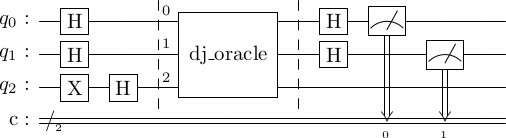

operations:  
{'u': 7, 'measure': 2}



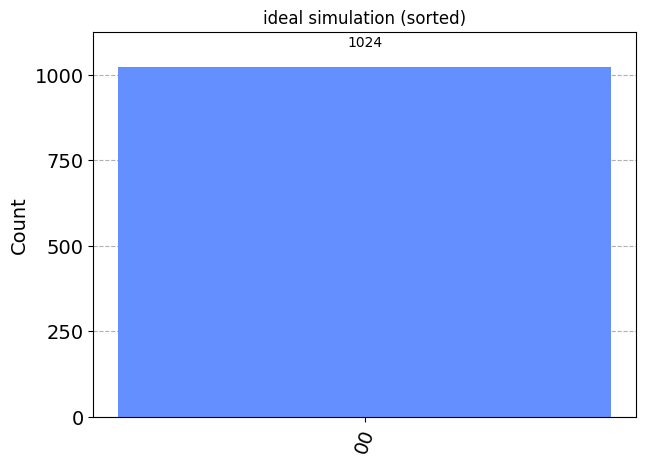

measurement counts:  
{'00': 1024}



In [8]:
if i != 9 and dict(circuit[circuit_index].count_ops())['measure'] > 10:
    print('measure > 10')
elif i == 9 and dict(circuit[circuit_index].count_ops())['measure'] > 20:
    print('measure > 20 (qunatum key distribution)')
else:
    show_circuit(circuit[circuit_index], 0, output = 'latex', style = 'bw')
    # show_circuit(circuit[circuit_index], 0, output = 'mpl', style = 'bw')

    ops = dict(decomposer(circuit[circuit_index], 8).count_ops())
    
    try:
        del ops['barrier']
    except:
        # print('no barrier')
        pass
        
    print('operations:  ')
    print(ops)
    print()
    
    with open('sim_measurement_cpu/' + f"{i:02}_" + algorithm[i] + '_sim_result.pickle', 'rb') as f:
        results = pickle.load(f)
    
    sim_result = results[circuit_index]
    sort = False
    show_plot = 1
    show_counts = 1
    verbose = False
    
    try:
        sim_time, raw_counts, sorted_counts = sim_result_analysis(sim_result, sort, show_plot, show_counts, verbose)
    except:
        print('error happend at '+ algorithm[i], circuit_index)
    
    print()

In [10]:
for count in list(range(10)):

    if circuit[count].num_qubits > 10:
        print('num_qubits > 10')
        break
        
    print('# ' + f"{i:02}_" + algorithm[i] + '_' + str(count))
    
    try:
        with gzip.open('sim_statevector_qiskit/' + f"{i:02}_" + algorithm[i] + '/sim_result_' + f"{count:02}" +'.txt.gz','r') as f:        
            print('state vector:  ')
            for line in f:
                print(line.decode()[:-1]+'  ')
            print()
            
        count += 1
    except:
        print('error happend at '+ algorithm[i], count)
        break

# 00_deutsch_jozsa_0
state vector:  
 (-7.071067811865474617e-01+1.731912112470986572e-16j)  
 (-2.651225781177655398e-33-4.329780281177466429e-17j)  
 (5.551115123125782702e-17-4.329780281177466429e-17j)  
 (2.651225781177656082e-33+6.162975822039154730e-33j)  
 (7.071067811865474617e-01-1.731912112470986079e-16j)  
 (2.651225781177654714e-33+4.329780281177466429e-17j)  
 (0.000000000000000000e+00+4.329780281177465196e-17j)  
 (-2.651225781177655398e-33+0.000000000000000000e+00j)  

# 00_deutsch_jozsa_1
state vector:  
 (7.071067811865474617e-01-2.164890140588732845e-16j)  
 (5.302451562355308744e-33+4.329780281177466429e-17j)  
 (2.651225781177655398e-33+4.329780281177466429e-17j)  
 (-2.651225781177655056e-33+4.357881996052623737e-33j)  
 (0.000000000000000000e+00+4.329780281177467662e-17j)  
 (-2.651225781177655740e-33+6.162975822039154730e-33j)  
 (-2.651225781177656082e-33-6.162975822039154730e-33j)  
 (0.000000000000000000e+00+4.357881996052623053e-33j)  
 (-7.071067811865474617